# Introduction

This pipeline takes a list of text bodies and then applies topic modelling and sentiment analysis to each entry. The final output of this process is a report on any significant correlations between topics and sentiments.
This is intended as an extensible prototype. This pipeline can be configured to work with any list of text bodies, but is here used to assess if news articles are treating topics particularly positively or negatively. In future, this prototype could be developed for applications such as assessing bias in different media outlets, or estimating the impact of media sentiment on public opinion. 


# Literature *Review*

NLP techniques have often been used in automated public opinion analysis. As opposed to analyzing a population’s thoughts about a topic through surveys or interviews, NLP can be used to determine the public’s thoughts and feelings about a topic based on what they are saying and writing. The advent of social media provides researchers with massive amounts of text content to analyze for public opinion. There is much research using topic modelling and sentiment analysis together to assess what topics the corpus features and how positively or negatively that topic is being discussed. (Heidenreich et al, 2019; Ilyas et al, 2020)

Automated public opinion analysis has been developed since the 2010s. LDA and sentiment analysis with the VADER system has in particular, risen in popularity among researchers. Using these two NLP techniques together can yield a ‘sentiment per topic’ distribution. Certain researchers have discovered interesting correlations with actual public and economic events and certain sentiments-on-topics. (Sokolova et al, 2017; Yakunin et al, 2020, Zhou et al, 2017)

The role of the media in public opinion formation is also an important research topic. The same techniques that analyze sentiment per topic in public discourse can also be applied to news media. This project aims to apply these NLP techniques for topic modeling and sentiment analysis to yield the sentiment per topic of news media articles. This could be used to research the impact of media discourse on public opinion. (Sokolova et al, 2017; Yakunin et al, 2020)


## Demonstration
What follows is a demonstration of the pipeline execution.

# Configuration

In the following section, we:

* Import required modules
* Set the configuration constants, including the tokenizer functions, stop words, etc. 
* Define the functions for use in the 'Execution' section.
* Connect this runtime to file storage (Google Drive) to store the output file. 

## Modules

In [ ]:
import pandas as pd
import seaborn as sb
import nltk
from scipy import stats
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
import time
import random
import os
import re
import numpy as np
from gensim import corpora
from gensim.models import CoherenceModel 
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
%matplotlib inline

In [ ]:
%%capture
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')

In [ ]:
%%capture
!pip install pyLDAvis
import pyLDAvis
from pyLDAvis import gensim_models
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Constants

The constants to be set for this pipeline are:

* INPUT_FILE - The location of the input file, which can be the same as the output file of the preceeding, web scraper pipeline. 
* TEXT_COLUMN - The column header of the column which is the text bodies. 
* STOP_WORDS - A selected NLTK stopwords object
* EXTENDED_STOP_WORDS - A list of extra stop words to include. 
* EXCLUDE_CHARACTERS - A set of characters to exclude, such as punctuation. 
* TOKENIZER_FUNCTION - The tokenizer function to be applied to the corpus.
* PASSES - The number of passes conducted by the LDA.
* GRAM_N - Set 2 for bigrams, 3 for trigrams, etc. 
* DELIMITER - Typically white space, this is used to concatenate tokens into the normalized text blobs. 
* NUM_TOPICS - A list of integers, this is the number of topics the LDA will try and select the most coherent one. 
* ALPHA - The significance threshold for testing if there are significant relationships between sentiments and topics. 
* SEED - Random seed. 

In [ ]:
INPUT_FILE = '/content/drive/MyDrive/MA5851_A3/scrape_results.csv'
TEXT_COLUMN ="Bag Of Words"
STOP_WORDS = stopwords.words('english')
EXTENDED_STOP_WORDS = ['m','u','also','est','span','a','n','said','time','one'] 
EXCLUDE_CHARACTERS = set(string.punctuation)
TOKENIZER_FUNCTION = WordNetLemmatizer().lemmatize
NUM_TOPICS=12
PASSES=50
#Set bigram, trigram, etc
GRAM_N = 2
DELIMITER = b' '
NUM_TOPICS = [3,5,7,10,15]
ALPHA = 0.05
SEED = 42

## File Storage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Functions

In [ ]:
def Clean(doc, tokenizer, exclude, stop):
  """Applies cleaning and lowercasing, tokenizing and stop word removal to the inputted text document"""
  stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
  punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
  normalized = " ".join(tokenizer(word) for word in punc_free.split())
  return normalized

In [ ]:
def Sent_To_Words(sentences):
  """Converts sentences to individual words, removes punctuation and converts to lowercase"""
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))

In [ ]:
def Make_Ngrams(texts, gram_mod):
  """Converts text to list of nGrams"""
  return [gram_mod[doc] for doc in texts]

In [ ]:
def Get_Tuple_Value(tup: tuple, x: int):
  """Returns the value from an inputted tuple."""
  return tup[x]

In [ ]:
def Filter_By_P_Value(coef, p_values, alpha):
  """Input a table of correlation coefficients and a table of their p-values. 
  returns the coefficients table with any entries with an insignificant 
  p value filtered out"""
  output = coef.copy(deep =True)
  for column in p_values:
    for i, j in p_values[column].items():
      if j > alpha:
        output.loc[i, column] = float("NaN")
  return output

def Add_P_Value_Markers(coef, p_values, alpha, character):
  """Input a table of correlation coefficients and the corresponding p values. 
  Outputs a table with the * marks for significance."""
  output = coef.copy(deep =True)
  for column in p_values:
    for i, j in p_values[column].items():
      if j < alpha:
        output.loc[i, column] = str(coef.loc[i, column].round(decimals = 6)) + character
      else:
        output.loc[i, column] = coef.loc[i, column]
  return output

def Pearsonr_Pval(x,y):
  """Applies the pearson regression to the x and y series"""
  return stats.pearsonr(x,y)[1]

def Set_All_Seeds(seed):
  """Set all random seeds in the runtime with one function"""
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  np.random.RandomState(seed)

In [ ]:
def tokenize(text):
  trans_table = {ord(c): None for c in string.punctuation + string.digits}    
  stemmer = PorterStemmer()
  tokens = [word for word in nltk.word_tokenize(text.translate(trans_table)) if len(word) > 1]
  stems = [stemmer.stem(item) for item in tokens]
  return stems

In [ ]:
def Plot_Word_Count(n: int,text_bodies):
  vectorizer = CountVectorizer(max_features=n,stop_words=STOP_WORDS,tokenizer=tokenize)
  Y = vectorizer.fit_transform(text_bodies)
  word_counts = Y.toarray().sum(axis=0)
  key_words = vectorizer.get_feature_names()
  df = pd.DataFrame({"Token":key_words,"Frequency":word_counts})
  df = df.sort_values(by='Frequency', ascending=False)
  df.iloc[0:n,:].plot.bar(x='Token', y='Frequency', rot=90)

# Execute

## Data Preprocessing

### Sentiment Analysis
The raw data inputted into this pipeline features:

*	The URL of the news article
*	The blob of text extracted the article
*	The title of the article

Figure 1 shows the word counts across the whole corpus. 

The previous pipeline has already tested that no articles appear to be missing substantial body text, which could be caused, for example, from the web crawler failing to extract meaningful text. 

Now we clean this text and convert it to vector space by:

*	Cleaning the text of unwanted characters (ie: ‘>’, ‘\’)
*	Converting all text to lowercase. 
*	Tokenize with the WordNet lemmatizer. See hyperparameter selection section for details. 
*	Removing stop words from the NLTK English stop word list, plus custom stop words identified by exploring the residual html text in the corpus. 
*	Applying the genism simple text cleaning, which removes punctuation, accents.

This list of normalized text blobs is sufficient input for the VADER sentiment analysis function. This system can then output the sentiment metrics for each text blob. 

###Topic Modelling
The LDA topic modeler requires some features in addition to the text normalization committed so far. To prepare the data for topic modelling we:

*	Apply nGram modification – in this case we select bigrams. See hyperparameter section for details. 

Now we can derive the document-term matrix for each bigram and document and input this to an LDA model for topic analysis. 


In [ ]:
Set_All_Seeds(SEED)
start_time = time.time()

In [ ]:
data = pd.read_csv(INPUT_FILE)
len(data)

155

In [ ]:
%%capture
#Select list of documents from data 
STOP_WORDS.extend(EXTENDED_STOP_WORDS)
# String cleaning
doc_clean = [Clean(doc, tokenizer=TOKENIZER_FUNCTION,exclude=EXCLUDE_CHARACTERS,stop=set(STOP_WORDS)).split() for doc in data[TEXT_COLUMN]]

#Make Ngrams
words = Sent_To_Words(doc_clean)
gram_mod = gensim.models.Phrases(words, min_count=GRAM_N, delimiter=DELIMITER)
ngrams = Make_Ngrams(doc_clean, gram_mod)

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(ngrams)

# Converting list of documents into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in ngrams]

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

corpus = [dictionary.doc2bow(text) for text in ngrams]


Figure 1: Word frequency in raw corpus

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'arent', 'becaus', 'befor', 'couldnt', 'didnt', 'doe', 'doesnt', 'dont', 'dure', 'ha', 'hadnt', 'hasnt', 'havent', 'hi', 'isnt', 'mightnt', 'mustnt', 'neednt', 'onc', 'onli', 'ourselv', 'shant', 'shouldnt', 'shouldv', 'thatll', 'themselv', 'thi', 'veri', 'wa', 'wasnt', 'werent', 'whi', 'wont', 'wouldnt', 'youd', 'youll', 'yourselv', 'youv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


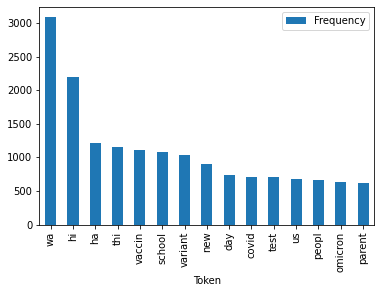

In [ ]:
Plot_Word_Count(15, data[TEXT_COLUMN])

## Sentiment Analysis

VADER is a dictionary based approach to estimating overall text sentiment and outputs the estimated positive, neutral and negative content of the text. VADER has been a popular sentiment analysis method for researchers since the 2010s. (Karansinh, 2020; Nemes & Attila, 2021)

### Hyperparameters
Because this is a prototype, there is minimal hyperparameter tuning.
The hyperparameters that have been selected are:

*	The default VADER dictionary is applied. 
*	The WordNet lemmatizer is used to tokenize the text. This choice of tokenizer was arbitrary for the prototype. Future iterations could involve tokenizer selection by grid searching. 

Figure 2 shows the distribution of overall sentiment (1 for positive, -1 for negative) across each article in the data. 

In [ ]:
vader = SentimentIntensityAnalyzer()
sentiment_scores = []
for doc in data[TEXT_COLUMN]:
  sentiment_scores.append(vader.polarity_scores(doc))

In [ ]:
sentiments = pd.DataFrame(sentiment_scores)

Text(0.5, 1.0, 'Figure 2: Distribution of Sentiment across Articles')

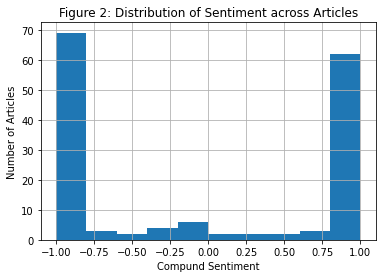

In [ ]:
ax = sentiments['compound'].hist()
ax.set_xlabel("Compund Sentiment")
ax.set_ylabel("Number of Articles")
ax.set_title("Figure 2: Distribution of Sentiment across Articles")

## Topic Modelling

LDA is a popular algorithm for topic modelling. It was selected because it is used in preceding research into public opinion analysis and this experiment is aimed at recreating this topic modelling with media as the target corpus. 

LDA is an un-supervised machine learning algorithm. There is a pre-defined number of topics (k) to detect across the inputted articles. LDA consumes a document-term-matrix, which is the frequency of terms (in this case, every unique bigram in the corpus) per each document. This matrix can then be used to discern k number of distinct clusters with distance-function-based clustering algorithms. (Rabitz, 2021; “Topic Modeling: A Comprehensive Review - ProQuest.”, 2021)

Finally, we optimize the value of k by grid searching candidate values and selecting the k value with the most topic coherency. Coherence, in this case measured by the popular 'c_v' metric, is the overall cosine similarity of all documents in a topic. (Röder  et al, 2015). Figure 3 shows the coherence for different k values. The k value with the highest coherence will be selected. 

Once we have the optimum number of topics to search for in a corpus, we can visualise topics by using PCA to project our n-dimensional document-term-matrix to 2 dimensions (figure 5-left). Figure 5-right features an interactive visualisation which lets us view the saliency of terms per topic. Saliency is a measure of how much a particular token brings a document closer to a particular cluster centroid (which is a topic). This means that we can see, for each topic, the terms which most characterize that topic. (Alteryx Community, 2020)


### Hyperparameters
The LDA will use the same normalized corpus as the sentiment analyzer. There are two additional hyperparameters for the LDA:

*	N value for nGram modification: We converted the tokenized text into bigram terms. This was an arbitrary selection for the prototype which can be tuned with grid search in future iterations. 

*	The K value for number of topics to be modelled. This hyperparameter was found through grid search of this one variable. The user sets a range of k values to test. The pipeline tries each one and selects the k value with the highest overall coherence. Figure 3 and 4 indicate the results of automatically tuning this hyperparameter. 


In [ ]:
%%capture
max_coherence = 0
optimal_n_topics = 0
perplexity_scores = []
coherence_scores = []
MINIMUM_PROBABILITY = 0.0
for n in NUM_TOPICS:
  ldamodel = Lda(doc_term_matrix, num_topics=n, id2word = dictionary, passes=PASSES, minimum_probability=MINIMUM_PROBABILITY)
  perplexity = ldamodel.log_perplexity(corpus)
  coherence = CoherenceModel(model=ldamodel, texts=ngrams, dictionary=dictionary, coherence='c_v').get_coherence()
  perplexity_scores.append(perplexity)
  coherence_scores.append(coherence)
  if coherence > max_coherence:
    max_coherences = coherence
    optimal_n_topics = n
ldamodel = Lda(doc_term_matrix, num_topics=optimal_n_topics, id2word = dictionary, passes=PASSES, minimum_probability=MINIMUM_PROBABILITY)

Text(0.5, 1.0, 'Figure 3: Coherence')

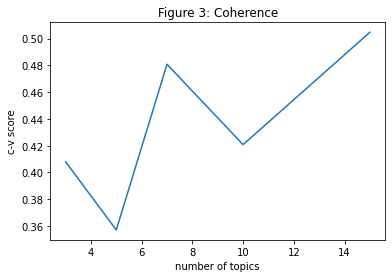

In [ ]:
plt.plot(NUM_TOPICS,coherence_scores)
plt.xlabel('number of topics')
plt.ylabel('c-v score')
plt.title('Figure 3: Coherence')

Text(0.5, 1.0, 'Figure 4: Perplexity')

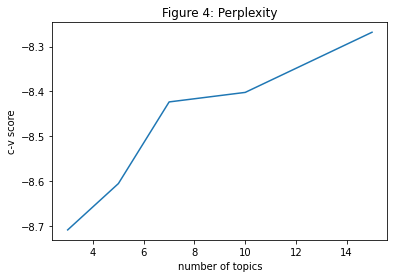

In [ ]:
plt.plot(NUM_TOPICS,perplexity_scores)
plt.xlabel('number of topics')
plt.ylabel('c-v score')
plt.title('Figure 4: Perplexity')

Figure 5: Topic Modeling Results

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.153733  0.330744       1        1  21.668550
4      0.176577  0.025235       2        1  16.958660
5     -0.073785 -0.078967       3        1   9.876956
12     0.220536  0.108293       4        1   7.514706
2      0.031841 -0.051543       5        1   7.306137
14     0.146082 -0.027463       6        1   7.097427
7     -0.120800 -0.065675       7        1   6.869842
9      0.142746 -0.001356       8        1   5.432055
13    -0.062585 -0.098553       9        1   4.685659
10    -0.041420 -0.027594      10        1   3.540726
0     -0.069001  0.023022      11        1   2.760994
8     -0.007010 -0.018911      12        1   2.760076
6     -0.083894 -0.082494      13        1   2.079820
11    -0.037927 -0.017852      14        1   1.440494
1     -0.067625 -0.016886      15        1   0.007899, topic_info=                          Term        Freq  ...  logprob  loglift
2496                    school  565.000000  ...   30.000  30.0000
357                    variant  433.000000  ...   29.000  29.0000
618                          m  295.000000  ...   28.000  28.0000
1277                    police  237.000000  ...   27.000  27.0000
80                       covid  244.000000  ...   26.000  26.0000
...                        ...         ...  ...      ...      ...
641                   november    0.000603  ...   -9.746  -3.5155
364                       week    0.000603  ...   -9.746  -3.4504
78                       could    0.000603  ...   -9.746  -3.6491
640   noopener stylefontweight    0.000603  ...   -9.746  -3.1922
827                          –    0.000603  ...   -9.746  -3.0780

[989 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
17062     12  0.647622    0128
3          2  0.945556  1030pm
4          2  0.493674    10pm
4         13  0.493674    10pm
4175       3  0.051463    11pm
...      ...       ...     ...
375        3  0.051487       —
375        4  0.471969       —
375        6  0.308925       —
375        8  0.102975       —
375       10  0.025744       —

[2305 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 6, 13, 3, 15, 8, 10, 14, 11, 1, 9, 7, 12, 2])

Here, we give each topic a name based on the top three most salent words.

In [ ]:
topics = pd.DataFrame(ldamodel[corpus])
topics = topics.applymap(lambda x: Get_Tuple_Value(x,1))

In [ ]:
column_names_raw = pd.DataFrame(ldamodel.print_topics(num_topics = optimal_n_topics, num_words = 5))[1]
column_names = []
for name in column_names_raw:
  name = str(re.findall('"([^"]*)"',name))
  column_names.append(name)
topics.columns = column_names

## Regression Analysis

The results from the sentiment analysis and the topic modelling are appended as new columns to the original data set, which gives us the following new schema:

Each topic (there will be k number of topics, and therefore columns.

*	This is a float which indicates the estimation that this article is about this topic. The larger the value, the more this article appears to involve a discussion of this topic. 

*	For readability, topics are named by taking the top 3 most salient words in the topic and appending them into a list. This is to give the reader some insight into what the topic regards. 

Four sentiment variables:

*	Neu: The normalized sum amount of terms which are neither positive or negative
*	Pos: Positive terms (according to the VADER dictionary)
*	Neg: Negative terms
*	Compound: The normalized mean of positive minus negative sentiment. 

From this data, we can output the final deliverable from this pipeline: We want to know if any topics have a significant correlation with any of the sentiment metrics. We use pairwise Pearson regression to determine if an article that is more about a given topic, has a significant correlation with a sentiment. 

Figure 6 shows this output. Note than variable pairs where the correlation is not significant (p< 0.05) are blank. 


In [ ]:
regression_analysis_data = pd.concat([topics,sentiments], axis = 1)
len(regression_analysis_data)

155

Text(0.5, 1.0, 'Figure 6: Correlation Coefficients - Topics and Sentiments')

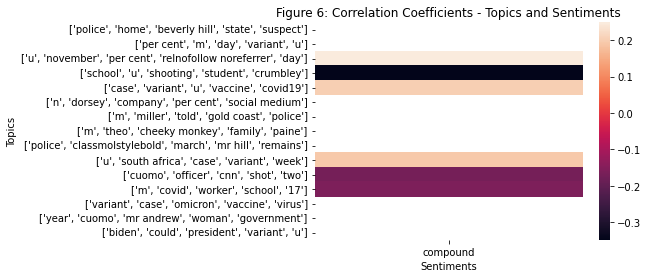

In [ ]:
sentiment_variables = ["neg","neu","pos","compound"]
corr = regression_analysis_data.corr()
p_values = regression_analysis_data.corr(method = Pearsonr_Pval)
vis_data = Filter_By_P_Value(corr,p_values,ALPHA)
ax = plt.axes()
sb.heatmap(vis_data.loc[:,["compound"]].drop(sentiment_variables, axis = 0), ax=ax)
ax.set_xlabel("Sentiments")
ax.set_ylabel("Topics")
ax.set_title('Figure 6: Correlation Coefficients - Topics and Sentiments')

In [ ]:
execution_time = time.time() - start_time
execution_time

293.3837351799011

# Discussion

Figure 5-left shows a number of topics, many of which overlap. We can see from this figure that there are 3 very distinct topic areas, but within these three areas, there's a variety of slightly overlapping topics. This may indicate that even with optimized coherence, there may be a better way to arrive at an optimal value for k. 

Figure 6 indicates the identified news topics, many of which have no significant correlation with sentiment. This indicates that there is just not enough of a reliable connection between the topic and sentiment variables to be sure of a clear connection. 

Some topics do appear to have a significant relation with the sentiment, such as:

* Stories about a recent school shooting in the USA tend to have very negative sentiments.
* Stories about the trial of former Governor Andrew Cuomo tend towards negative sentiment. 
* Stories about the new omicron covid variant tend to have positive sentiment. 

There are some issues with these results. Firstly, some of these topics overlap. A human reader might consider covid and the new variant to be a single topic, but the LDA has interpreted these as distinct. This means several topics appear to all be about covid. Secondly, it would be intuitive to guess that covid would typically have negative sentiment, but this analysis shows positive sentiment for covid stories. This may be because the news outlet is publishing stories about recovery from the pandemic, which have positive connotations. Alternatively it could be that the VADER dictionary is being confounded. This would need to be investigated manually to determine if the automatic quality metrics are incorrect. 

# Refferences

Alteryx Community. “Getting to the Point with Topic Modeling | Part 3 - Interpreting the Visualization,” August 5, 2020. https://community.alteryx.com/t5/Data-Science/Getting-to-the-Point-with-Topic-Modeling-Part-3-Interpreting-the/ba-p/614992.

Heidenreich, Tobias, Fabienne Lind, Jakob-Moritz Eberl, and Hajo G Boomgaarden. “Media Framing Dynamics of the ‘European Refugee Crisis’: A Comparative Topic Modelling Approach.” Journal of Refugee Studies 32, no. Special_Issue_1 (December 1, 2019): i172–82. https://doi.org/10.1093/jrs/fez025.

Ilyas, Sardar Haider Waseem, Zainab Tariq Soomro, Ahmed Anwar, Hamza Shahzad, and Ussama Yaqub. “Analyzing Brexit&#x2019;s Impact Using Sentiment Analysis and Topic Modeling on Twitter Discussion.” In The 21st Annual International Conference on Digital Government Research, 1–6. Dg.o ’20. New York, NY, USA: Association for Computing Machinery, 2020. https://doi.org/10.1145/3396956.3396973.

Karansinh, Raj. “Automation of Sentiment Analysis & Topic Modeling Using Py-Spark & SparkNLP (Twitter Data).” Medium, September 28, 2020. https://towardsdatascience.com/automation-of-sentiment-analysis-topic-modeling-using-py-spark-sparknlp-twitter-data-2b2d55b5198d.

Li, Xin, and Lei Lei. “A Bibliometric Analysis of Topic Modelling Studies (2000–2017).” Journal of Information Science 47, no. 2 (April 1, 2021): 161–75. https://doi.org/10.1177/0165551519877049.

Nemes, László, and Attila Kiss. “Social Media Sentiment Analysis Based on COVID-19.” Journal of Information and Telecommunication 5, no. 1 (January 2, 2021): 1–15. https://doi.org/10.1080/24751839.2020.1790793.

Rabitz, Florian, Audronė Telešienė, and Eimantė Zolubienė. “Topic Modelling the News Media Representation of Climate Change.” Environmental Sociology 7, no. 3 (July 3, 2021): 214–24. https://doi.org/10.1080/23251042.2020.1866281.

Röder, Michael, Andreas Both, and Alexander Hinneburg. “Exploring the Space of Topic Coherence Measures.” In Proceedings of the Eighth ACM International Conference on Web Search and Data Mining, 399–408. Shanghai China: ACM, 2015. https://doi.org/10.1145/2684822.2685324.

Sokolova, Marina, Kanyi Huang, Stan Matwin, Joshua Ramisch, Renee Black, Chris Orwa, Sidney Ochieng, and Nanjira Sambuli. “Topic Modelling and Event Identification from Twitter Textual Data,” n.d., 17.

“Topic Modeling: A Comprehensive Review - ProQuest.” Accessed November 27, 2021. https://www.proquest.com/openview/833a218788f7c1fa9410d0056d9fdbff/1?pq-origsite=gscholar&cbl=4477225.

Yakunin, Kirill, Ravil Mukhamediev, Rustam Mussabayev, Timur Buldybayev, Yan Kuchin, Sanzhar Murzakhmetov, Rassul Yunussov, and Ulzhan Ospanova. “Mass Media Evaluation Using Topic Modelling.” In Digital Transformation and Global Society, edited by Daniel A. Alexandrov, Alexander V. 
Boukhanovsky, Andrei V. Chugunov, Yury Kabanov, Olessia Koltsova, and Ilya Musabirov, 165–78. Communications in Computer and Information Science. Cham: Springer International Publishing, 2020. https://doi.org/10.1007/978-3-030-65218-0_13.

Zhou, Xujuan, Xiaohui Tao, Md Rahman, and Ji Zhang. “Coupling Topic Modelling in Opinion Mining for Social Media Analysis,” 533–40, 2017. https://doi.org/10.1145/3106426.3106459.



# Glossary

* LDA - Latent Dirichlet Allocation
* NLP - Natural Language Processing
* VADER - Valence Aware Dictionary and sEntiment Reasoner